# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

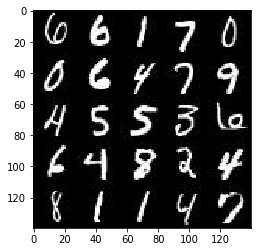

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

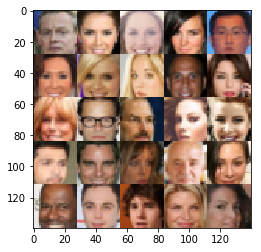

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.14.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ = tf.placeholder(shape=(None, image_width, image_height, image_channels), dtype=tf.float32)
    z = tf.placeholder(shape=(None, z_dim), dtype=tf.float32)
    learning_rate = tf.placeholder(shape=None, dtype=tf.float32)

    return input_, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

W0718 11:34:24.424902 140510682834688 deprecation_wrapper.py:119] From /home/workspace/face_generation/problem_unittests.py:20: The name tf.assert_rank is deprecated. Please use tf.compat.v1.assert_rank instead.



Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    _, WIDTH, HEIGHT, DEPTH = images.shape # Input Layer is 28x28x1 in case of mnist and 28x28x3
    alpha = 0.2 
    filters = [64, 128]
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # First Layer
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(x1, x1*alpha) #Leaky ReLU
        # Now, it's 14x14x64
        
        # Second Layer
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha) #Leaky ReLU
        # Now, it's 7x7x128
        
        # Output
        flat = tf.reshape(x2, (-1, 7*7*filters[-1])) # now, its shape is (None, 1024)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*128)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.reshape(x, shape=(-1, 7, 7, 128))
        # Now, it's 7x7x256
        
        # First Layer
        x1 = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.math.maximum(x1, x1*alpha) #Leaky ReLU
        # Now, it's 14x14x128
        
#         # Second Layer
#         x2 = tf.layers.conv2d_transpose(x1, filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.math.maximum(x2, x2*alpha) #Leaky ReLU
#         # Now, it's 28x28x64
        
#         # Third Layer
#         x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=training)
#         x3 = tf.math.maximum(x3, x3*alpha) #Leaky ReLU
#         # Now, it's 32x32x64
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x1, filters=out_channel_dim, kernel_size=(5, 5), strides=(2, 2), padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

W0718 11:35:58.102272 140510682834688 deprecation.py:323] From <ipython-input-9-3a32e890c448>:20: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

W0718 11:36:03.648466 140510682834688 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

W0718 11:36:12.353671 140510682834688 deprecation_wrapper.py:119] From /home/workspace/face_generation/problem_unittests.py:46: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
from tqdm import tqdm_notebook as tqdm


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
       
    # Get image dims
    total_images, image_width, image_height, image_channels = data_shape

    # Create optimizers
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    # Create model saver
#     saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_idx, batch_images in tqdm(enumerate(get_batches(batch_size)), desc="Processing", total=total_images//batch_size):
                # Sample random noise for Generator network
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # I'm using tanh in the generator's last layer,
                # so the values in generated images will be in the range [-1,1], however the values in batch_images
                # here are in the range [-0.5, 0.5].
                # Hence you need to scale these values by using batch_images=batch_images*2.
                batch_images = batch_images*2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                # Show some results
                if batch_idx % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                if batch_idx % 20==0:
                    # Show losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

#         saver.save(sess, './checkpoints/generator.ckpt')   
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

HBox(children=(IntProgress(value=0, description='Processing: ', max=937), HTML(value='')))

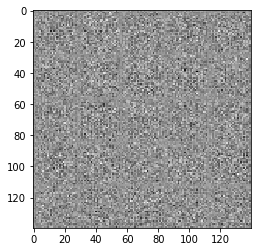

Epoch 1/2... Discriminator Loss: 2.7233... Generator Loss: 0.0801
Epoch 1/2... Discriminator Loss: 0.2047... Generator Loss: 1.9490
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 1.4148
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.3259


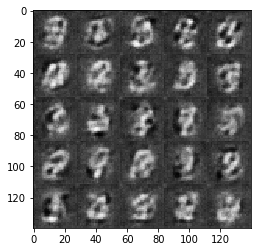

Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 1.5974
Epoch 1/2... Discriminator Loss: 1.7007... Generator Loss: 0.2453
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 1.7738
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 0.8458


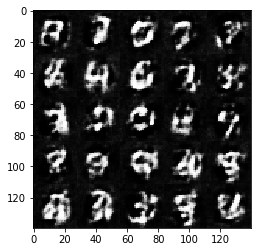

Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 1.8853
Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 0.8276... Generator Loss: 0.7779


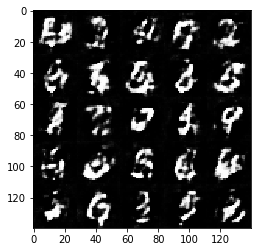

Epoch 1/2... Discriminator Loss: 0.5761... Generator Loss: 1.4086
Epoch 1/2... Discriminator Loss: 0.8520... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 0.7151... Generator Loss: 1.3300
Epoch 1/2... Discriminator Loss: 0.6618... Generator Loss: 1.3755


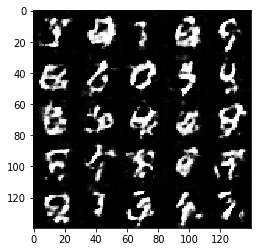

Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 1.6015
Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.0520
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.3925
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.5065


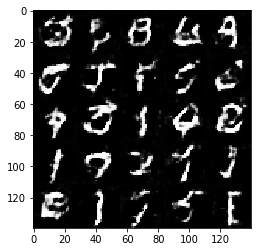

Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.4673
Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 1.5689
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 1.3301


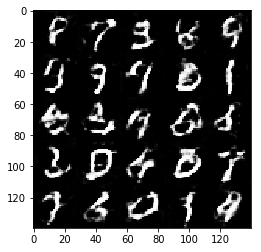

Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 1.0345
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 1.9776
Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 1.9072


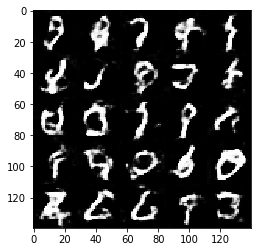

Epoch 1/2... Discriminator Loss: 0.8262... Generator Loss: 1.1236
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 0.9065
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 1.1630


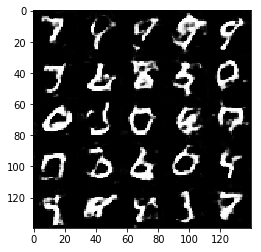

Epoch 1/2... Discriminator Loss: 0.5531... Generator Loss: 1.6888
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 1.1964
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 1.7345
Epoch 1/2... Discriminator Loss: 0.9153... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 0.9069


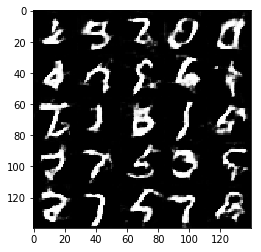

Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.5212
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.3495



HBox(children=(IntProgress(value=0, description='Processing: ', max=937), HTML(value='')))

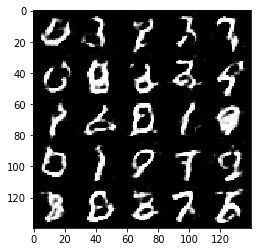

Epoch 2/2... Discriminator Loss: 0.6626... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 0.6248... Generator Loss: 1.1562
Epoch 2/2... Discriminator Loss: 0.5687... Generator Loss: 1.8569
Epoch 2/2... Discriminator Loss: 0.7119... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.6523


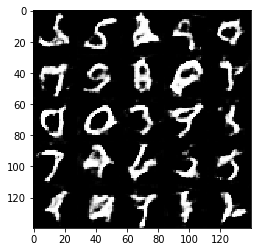

Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.3370
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 1.3208
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.5499
Epoch 2/2... Discriminator Loss: 0.4244... Generator Loss: 1.6389


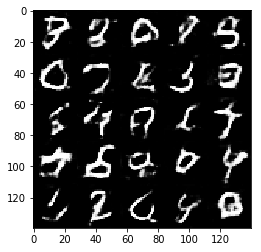

Epoch 2/2... Discriminator Loss: 0.6654... Generator Loss: 1.0640
Epoch 2/2... Discriminator Loss: 0.4542... Generator Loss: 1.7164
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 1.7176
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 1.9236
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 0.8512


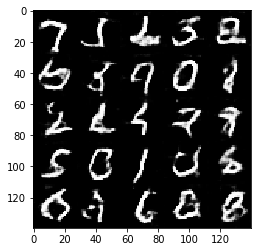

Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 0.7228
Epoch 2/2... Discriminator Loss: 0.5354... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 3.1454
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 1.4225


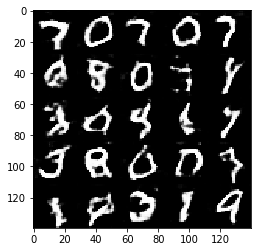

Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.1583
Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.5729
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 1.5447
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 1.7589
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 0.8515


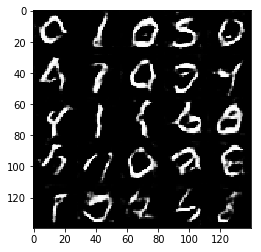

Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 0.8488
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 0.6540... Generator Loss: 1.5238
Epoch 2/2... Discriminator Loss: 0.5997... Generator Loss: 1.2527
Epoch 2/2... Discriminator Loss: 0.5336... Generator Loss: 1.2295


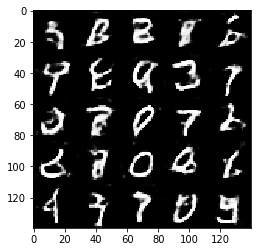

Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 0.4800... Generator Loss: 1.3174
Epoch 2/2... Discriminator Loss: 0.3821... Generator Loss: 1.6650
Epoch 2/2... Discriminator Loss: 0.4748... Generator Loss: 1.3910
Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 1.0898


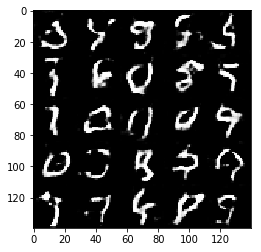

Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 1.9888
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.4348
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 1.5452
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 0.9286


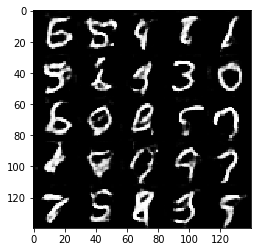

Epoch 2/2... Discriminator Loss: 0.7098... Generator Loss: 1.1755
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 1.6618
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 1.1706
Epoch 2/2... Discriminator Loss: 0.5545... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 0.3831... Generator Loss: 1.5755


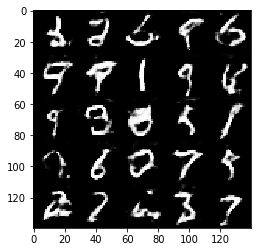

Epoch 2/2... Discriminator Loss: 0.4493... Generator Loss: 1.2661
Epoch 2/2... Discriminator Loss: 0.6654... Generator Loss: 0.9505



In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

HBox(children=(IntProgress(value=0, description='Processing: ', max=3165), HTML(value='')))

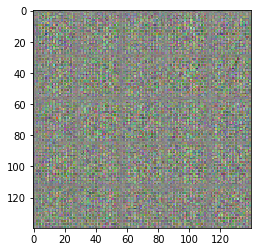

Epoch 1/1... Discriminator Loss: 2.9631... Generator Loss: 0.0631
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 1.4759
Epoch 1/1... Discriminator Loss: 0.1696... Generator Loss: 2.3776
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 2.8835
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 1.3300


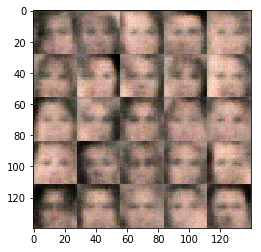

Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 4.0469... Generator Loss: 5.7558
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.2992
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 1.7121


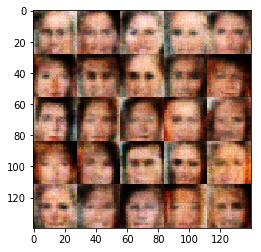

Epoch 1/1... Discriminator Loss: 1.8783... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.7849... Generator Loss: 1.6650
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8408


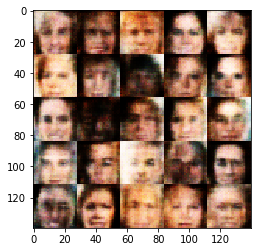

Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.3093
Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 1.4760
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 1.3490


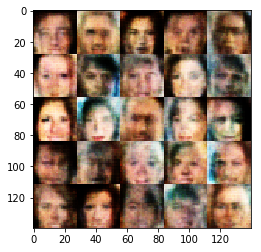

Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 1.7395


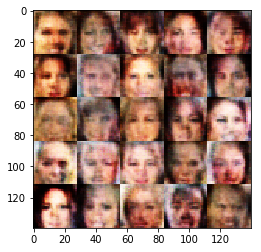

Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 1.5668
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.7847... Generator Loss: 0.2615


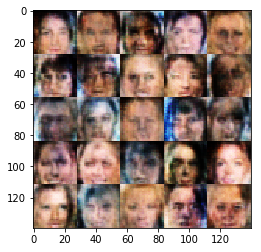

Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.2917
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.5776


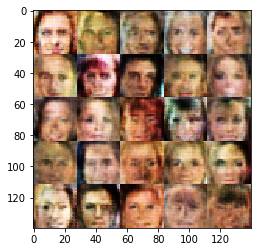

Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6845


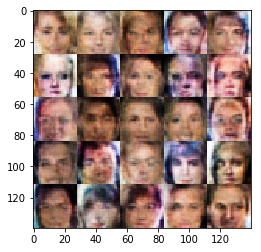

Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9653


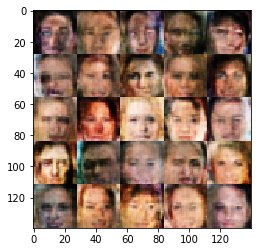

Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7577


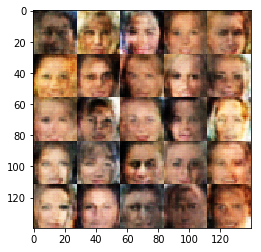

Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.3118
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.9097


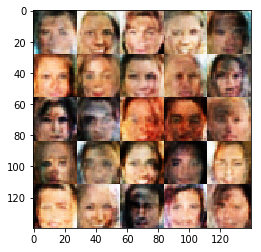

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 1.8230
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 2.3940
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 1.7966


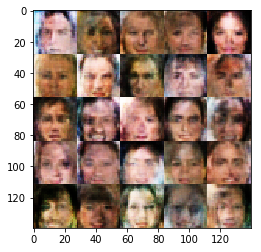

Epoch 1/1... Discriminator Loss: 1.5501... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 2.5226... Generator Loss: 0.1184
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.8024


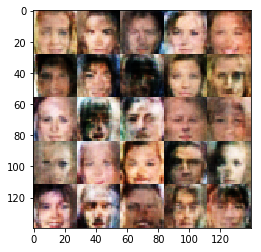

Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 1.3010


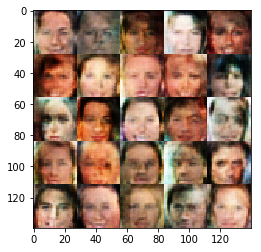

Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.4380
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.7128


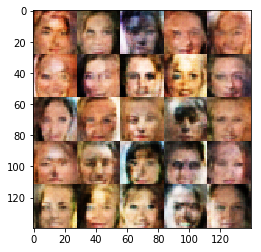

Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6244


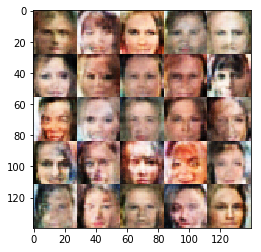

Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7661


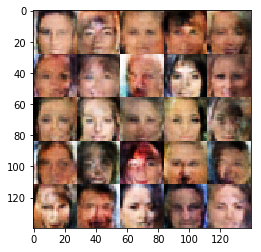

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.8861... Generator Loss: 0.2270
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8754


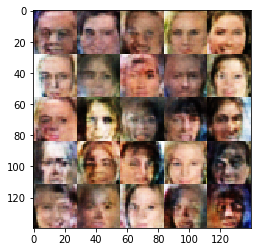

Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.3916


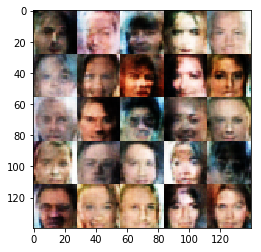

Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 1.0248


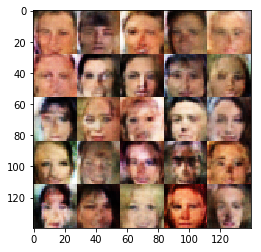

Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7494


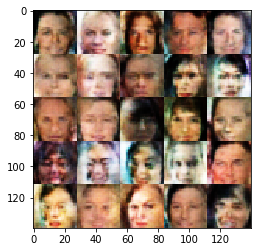

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.6397


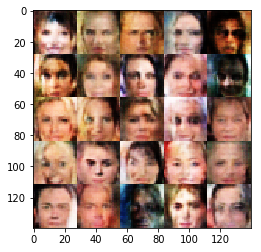

Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.4145


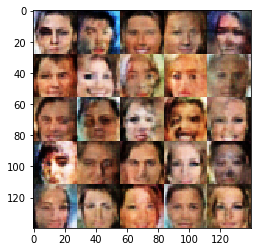

Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.3229
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.5595


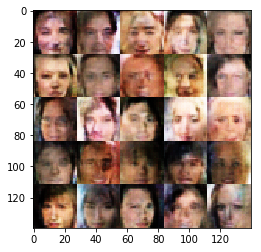

Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.9485
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6707


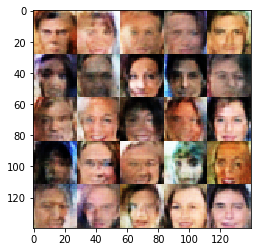

Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.5566


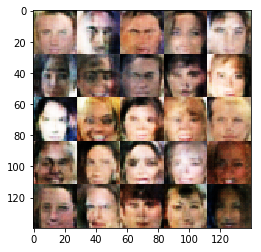

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7343


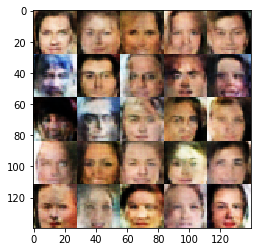

Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 1.8526... Generator Loss: 0.2305
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.4633


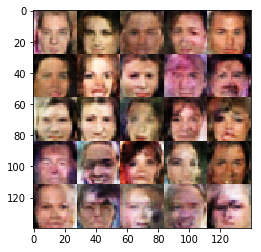

Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.6435


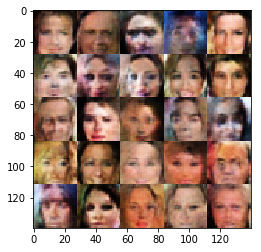

Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.3193
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.7355


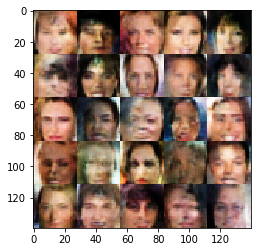

Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7389


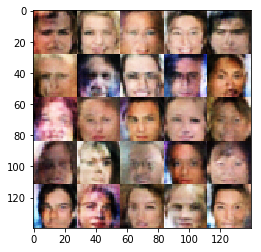

Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.6899



In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.